## Build a spam detector

In [1]:
import nltk 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [ ]:
# nltk.download_shell()
# download stopwords data

### 1. Read data

In [22]:
messages = pd.read_csv('data/SMSSpamCollection',sep='\t',names=['label','message'])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [23]:
## some basic summaries 
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [25]:
## some basic summaries 
messages.groupby('label').describe()

message
label                                                          
ham   count                                                4825
      unique                                               4516
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4

### 2. Feature engeerning 

In [26]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


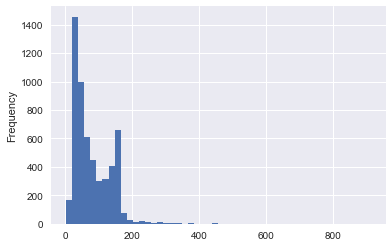

In [27]:
## distribution of the length 
messages.length.plot.hist(bins=50)

In [28]:
## see, the longest is really long, 910 words 
messages.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x117a375f8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x117b23d30>], dtype=object)

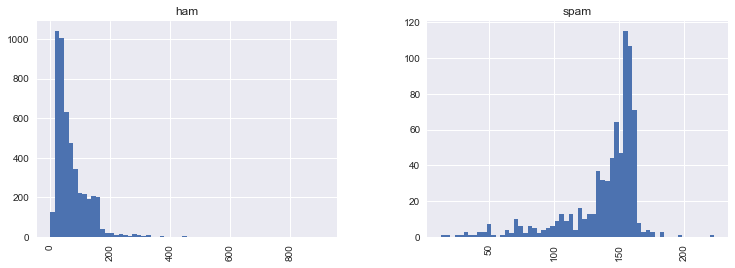

In [29]:
## compare the distribution between ham and spam 
messages.hist(column='length',by='label',bins=60,figsize=(12,4))

So we can see that message length might be a good feature to include 

### 3. Data pre-process, stopwords, tokenization etc

1.remove punctuations 

In [31]:
import string  # used for remove punctuation

In [40]:
## example 
print(string.punctuation)
mess = 'This is you message. And the other one is mine! Do not touch mine. OK?'
nopunc = [c for c in mess if c not in string.punctuation]
print(''.join(nopunc))

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
This is you message And the other one is mine Do not touch mine OK


2 . remove stop workds

In [44]:
from nltk.corpus import stopwords
stopwords.words('english')[:10]  ## a whole list of english stopwords 

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your']

3.steming 

#### 4.define a function to remove punctuation and stop words 

In [46]:
def text_process(mess):
    """
    1. remove punc
    2. remove stop words
    """
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc=''.join(nopunc)
    nopunc = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    return nopunc 

In [47]:
messages['message'].apply(text_process)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


##### 5.tokenization

In [80]:
from sklearn.feature_extraction.text import CountVectorizer

In [81]:
## turn all the text into sparse matrix 
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages.message) ## tokenize all messages 
messages_bow = bow_transformer.transform(messages['message'])                  ## transform to sparse matrix 
# bow_transformer.vocabulary_     -- returns a dictionary of words and counts 
print('Shape of Sparse Matrix: ',messages_bow.shape)

Shape of Sparse Matrix:  (5572, 11425)


In [82]:
## use get_feature_name to get the token names
bow_transformer.get_feature_names()[1000:1005]

['Abt', 'Accept', 'Accident', 'AccommodationVouchers', 'Account']

In [96]:
## use tfidf
from sklearn.feature_extraction.text import TfidfTransformer

In [97]:
## turn orginal sparse matrix to tfidf
tfidf_transformer = TfidfTransformer().fit(messages_bow)
message_tfidf = tfidf_transformer.transform(messages_bow)

In [98]:
### if you want to see the tfidf for a specific word 
tfidf_transformer.idf_[bow_transformer.vocabulary_['university']]
### bow_transformer.vocabulary_['university'] returns an index 10747, 
### then get the 10747 item from transformer.idf_

8.527076498901426

### 4. Now train our data using naive beyes

In [110]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split

In [119]:
spam_detect_model=MultinomialNB().fit(message_tfidf,messages['label'])

In [120]:
pred_results = spam_detect_model.predict(message_tfidf)
pred_results

array(['ham', 'ham', 'spam', ..., 'ham', 'ham', 'ham'], 
      dtype='<U4')

#### But really, we need to use train and test data 

In [107]:
## split train and test data
## here we are actually split the originam data frame 
msg_train,msg_test,label_train,label_test=train_test_split(messages['message'],messages['label'],test_size=0.3)

##### here, we should re do the entire tokenization,and tfidf etc
##### or we can use sklearn pipeline feature 

In [108]:
from sklearn.pipeline import Pipeline

In [112]:
## use pipeline, pass in a list of tuples, all procedures you need to do 
pipeline= Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

In [113]:
## now we can just use pipeline to tran our data 
pipeline.fit(msg_train,label_train)
## now we have a fitted pipeline object 

Pipeline(steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x11746fa60>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [114]:
predictions = pipeline.predict(msg_test)

In [116]:
## report evaluation results 
from sklearn.metrics import classification_report 

In [118]:
print(classification_report(label_test,predictions))

             precision    recall  f1-score   support

        ham       0.95      1.00      0.98      1427
       spam       1.00      0.71      0.83       245

avg / total       0.96      0.96      0.95      1672

